<a href="https://colab.research.google.com/github/manabil/Tensorflow-Advanced-Techniques-Specialization/blob/main/Custom%20and%20Distributed%20Training%20with%20Tensorflow/Week%202/C2_W2_Lab_2_training_categorical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST using Custom Training Loop
In this ungraded lab, you will build a custom training loop including a validation loop so as to train a model on the [Fashion MNIST](https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/) dataset.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow_datasets as tfds
import matplotlib.ticker as mticker

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Load and Preprocess Data
You will load the [Fashion MNIST](https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/) dataset using Tensorflow Datasets. This dataset has 28 x 28 grayscale images of articles of clothing belonging to 10 clases.

Here you are going to use the training and testing splits of the data. Testing split will be used for validation.

In [2]:
train_data: tf.data.Dataset
info: object
train_data, info = tfds.load(
    "fashion_mnist",
    split="train",
    with_info=True,
    data_dir='./data/',
    download=True
)
test_data: tf.data.Dataset = tfds.load(
    "fashion_mnist",
    split="test",
    data_dir='./data/',
    download=True
)

In [3]:
class_names: list = [
    "T-shirt/top",
    "Trouser/pants",
    "Pullover shirt",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

Next, you normalize the images by dividing them by 255.0 so as to make the pixels fall in the range (0, 1). You also reshape the data so as to flatten the 28 x 28 pixel array into a flattened 784 pixel array.

In [4]:
def format_image(data: np.ndarray) -> tuple[np.ndarray, ...]:
    image: np.ndarray = data["image"]
    image = tf.reshape(image, [-1])
    image = tf.cast(image, 'float32')
    image = image / 255.0
    return image, data["label"]

In [5]:
train_data = train_data.map(format_image)
test_data = test_data.map(format_image)

Now you shuffle and batch your training and test datasets before feeding them to the model.

In [6]:
batch_size: int = 64
train: tf.Tensor = train_data.shuffle(buffer_size=1024).batch(batch_size)

test: tf.Tensor =  test_data.batch(batch_size=batch_size)

## Define the Model
You are using a simple model in this example. You use Keras Functional API to connect two dense layers. The final layer is a softmax that outputs one of the 10 classes since this is a multi class classification problem.

In [7]:
def base_model() -> tf.keras.Model:
  inputs: tf.keras.layers.Layer = tf.keras.Input(shape=(784,), name='digits')
  x: tf.keras.layers.Layer = tf.keras.layers.Dense(
      64, activation='relu', name='dense_1'
  )(inputs)
  x: tf.keras.layers.Layer = tf.keras.layers.Dense(
      64, activation='relu', name='dense_2'
  )(x)
  outputs: tf.keras.layers.Layer = tf.keras.layers.Dense(
      10, activation='softmax', name='predictions'
  )(x)
  model: tf.keras.Model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

## Define Optimizer and Loss Function

You have chosen `adam` optimizer and sparse categorical crossentropy loss for this example.

In [8]:
Loss = tf.keras.losses.Loss
optimizer: tf.keras.optimizers.Optimizer = tf.keras.optimizers.Adam()
loss_object: Loss = tf.keras.losses.SparseCategoricalCrossentropy()

## Define Metrics

You will also define metrics so that your training loop can update and display them. Here you are using `SparseCategoricalAccuracy`defined in `tf.keras.metrics` since the problem at hand is a multi class classification problem.

In [9]:
Metric = tf.keras.metrics.Metric
train_acc_metric: Metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric: Metric = tf.keras.metrics.SparseCategoricalAccuracy()

## Building Training Loop
In this section you build your training loop consisting of training and validation sequences.

The core of training is using the model to calculate the logits on specific set of inputs and compute loss (in this case **sparse categorical crossentropy**) by comparing the predicted outputs to the true outputs. You then update the trainable weights using the optimizer algorithm chosen. Optimizer algorithm requires your computed loss and partial derivatives of loss with respect to each of the trainable weights to make updates to the same.

You use gradient tape to calculate the gradients and then update the model trainable weights using the optimizer.

In [10]:
def apply_gradient(
    optimizer: tf.keras.metrics.Metric,
    model: tf.keras.Model,
    x: tf.data.Dataset,
    y: tf.data.Dataset
) -> tuple[tf.Tensor, ...]:
  with tf.GradientTape() as tape:
    logits: tf.Tensor = model(x)
    loss_value: tf.Tensor = loss_object(y_true=y, y_pred=logits)

  gradients: list = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))

  return logits, loss_value

This function performs training during one epoch. You run through all batches of training data in each epoch to make updates to trainable weights using your previous function. You can see that we also call update_state on your metrics to accumulate the value of your metrics.
You are displaying a progress bar to indicate completion of training in each epoch. Here you use tqdm for displaying the progress bar.

In [11]:
def train_data_for_one_epoch() -> list[tf.Tensor]:
  losses: list = []
  pbar: tqdm = tqdm(
      total=len(list(enumerate(train))),
      position=0,
      leave=True,
      bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} '
  )
  for step, (x_batch_train, y_batch_train) in enumerate(train):
      logits: tf.Tensor
      loss_value: tf.Tensor
      logits, loss_value = apply_gradient(
          optimizer, model, x_batch_train, y_batch_train
      )

      losses.append(loss_value)

      train_acc_metric(y_batch_train, logits)
      pbar.set_description(f"Training loss for step {step}: {loss_value:.4f}")
      pbar.update()
  return losses

At the end of each epoch you have to validate the model on the test dataset. The following function calculates the loss on test dataset and updates the states of the validation metrics.

In [12]:
def perform_validation() -> list[tf.Tensor]:
  losses: list = []
  for x_val, y_val in test:
      val_logits: tf.Tensor = model(x_val)
      val_loss: tf.Tensor = loss_object(y_true=y_val, y_pred=val_logits)
      losses.append(val_loss)
      val_acc_metric(y_val, val_logits)
  return losses

Next you define the training loop that runs through the training samples repeatedly over a fixed number of epochs. Here you combine the functions you built earlier to establish the following flow:
1. Perform training over all batches of training data.
2. Get values of metrics.
3. Perform validation to calculate loss and update validation metrics on test data.
4. Reset the metrics at the end of epoch.
5. Display statistics at the end of each epoch.

**Note** : You also calculate the training and validation losses for the whole epoch at the end of the epoch.

In [13]:

model: tf.keras.Model = base_model()

# Iterate over epochs.
epochs: int = 10
epochs_val_losses: list = []
epochs_train_losses: list = []

for epoch in range(epochs):
  print(f'Start of epoch {epoch}')

  losses_train: list[tf.Tensor] = train_data_for_one_epoch()
  train_acc: tf.Tensor = train_acc_metric.result()

  losses_val: list[tf.Tensor] = perform_validation()
  val_acc: tf.Tensor = val_acc_metric.result()

  losses_train_mean: np.float32 = np.mean(losses_train)
  losses_val_mean: np.float32 = np.mean(losses_val)
  epochs_val_losses.append(losses_val_mean)
  epochs_train_losses.append(losses_train_mean)

  print(f'Epoch {epoch}: Train loss: {losses_train_mean:.4f} \
  Validation Loss: {losses_val_mean:.4f}, \
  Train Accuracy: {train_acc:.4f}, Validation Accuracy {val_acc:.4f}\n')

  train_acc_metric.reset_states()
  val_acc_metric.reset_states()


Start of epoch 0


Training loss for step 937: 0.5230: 100%|██████████| 938/938 


Epoch 0: Train loss: 0.5433  Validation Loss: 0.4842, Train Accuracy: 0.8094, Validation Accuracy 0.8277

Start of epoch 1


Training loss for step 937: 0.2169: 100%|██████████| 938/938 


Epoch 1: Train loss: 0.3900  Validation Loss: 0.4269, Train Accuracy: 0.8587, Validation Accuracy 0.8462

Start of epoch 2


Training loss for step 937: 0.3261: 100%|██████████| 938/938 


Epoch 2: Train loss: 0.3534  Validation Loss: 0.3846, Train Accuracy: 0.8705, Validation Accuracy 0.8643

Start of epoch 3


Training loss for step 937: 0.3062: 100%|██████████| 938/938 


Epoch 3: Train loss: 0.3289  Validation Loss: 0.3738, Train Accuracy: 0.8795, Validation Accuracy 0.8651

Start of epoch 4


Training loss for step 937: 0.2376: 100%|██████████| 938/938 


Epoch 4: Train loss: 0.3128  Validation Loss: 0.3708, Train Accuracy: 0.8851, Validation Accuracy 0.8705

Start of epoch 5


Training loss for step 937: 0.2290: 100%|██████████| 938/938 


Epoch 5: Train loss: 0.2974  Validation Loss: 0.3454, Train Accuracy: 0.8907, Validation Accuracy 0.8769

Start of epoch 6


Training loss for step 937: 0.1352: 100%|██████████| 938/938 


Epoch 6: Train loss: 0.2871  Validation Loss: 0.3508, Train Accuracy: 0.8931, Validation Accuracy 0.8769

Start of epoch 7


Training loss for step 937: 0.3449: 100%|██████████| 938/938 


Epoch 7: Train loss: 0.2750  Validation Loss: 0.3739, Train Accuracy: 0.8980, Validation Accuracy 0.8699

Start of epoch 8


Training loss for step 937: 0.1773: 100%|██████████| 938/938 


Epoch 8: Train loss: 0.2676  Validation Loss: 0.3519, Train Accuracy: 0.9005, Validation Accuracy 0.8785

Start of epoch 9


Training loss for step 937: 0.1951: 100%|██████████| 938/938 


Epoch 9: Train loss: 0.2580  Validation Loss: 0.3517, Train Accuracy: 0.9038, Validation Accuracy 0.8800



## Evaluate Model

### Plots for Evaluation
You plot the progress of loss as training proceeds over number of epochs.

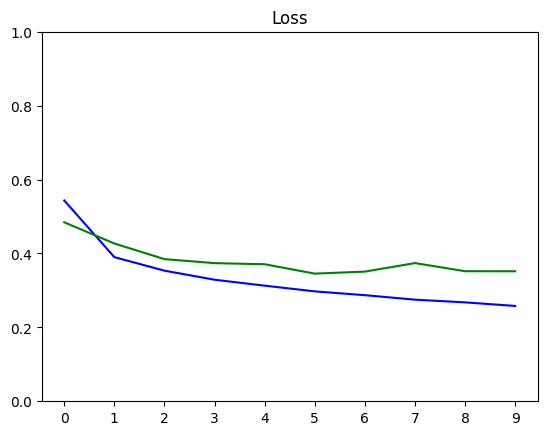

In [14]:
def plot_metrics(
    train_metric: list[np.float32],
    val_metric: list[np.float32],
    metric_name: str,
    title: str,
    ylim: float=5
) -> None:
  plt.title(title)
  plt.ylim(0,ylim)
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.plot(train_metric,color='blue',label=metric_name)
  plt.plot(val_metric,color='green',label='val_' + metric_name)

plot_metrics(epochs_train_losses, epochs_val_losses, "Loss", "Loss", ylim=1.0)

This function displays a row of images with their predictions and true labels.

In [15]:
# utility to display a row of images with their predictions and true labels
def display_images(
    image: np.ndarray,
    predictions: list[str],
    labels: list[str],
    title: str,
    n: int
) -> None:

  display_strings = [f"{i}\n\n{j}" for i, j in zip(predictions, labels)]

  plt.figure(figsize=(17,3))
  plt.title(title)
  plt.yticks([])
  plt.xticks([(28*x) + 14 for x in range(n)], display_strings)
  plt.grid(None)
  image = np.reshape(image, [n, 28, 28])
  image = np.swapaxes(image, 0, 1)
  image = np.reshape(image, [28, 28*n])
  plt.imshow(image)

You make predictions on the test dataset and plot the images with their true and predicted values.

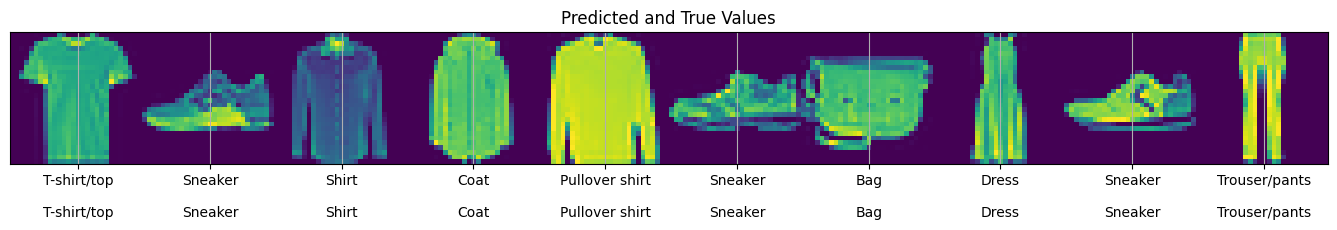

In [16]:
test_inputs: tf.data.Dataset = test_data.batch(batch_size=1000001)
x_batches: np.ndarray = np.array([])
y_pred_batches: np.ndarray = np.array([])
y_true_batches: np.ndarray = np.array([])

for x, y in test_inputs:
  y_pred: tf.Tensor = model(x)
  y_pred_batches = y_pred.numpy()
  y_true_batches = y.numpy()
  x_batches = x.numpy()

indexes: np.ndarray = np.random.choice(len(y_pred_batches), size=10)
images_to_plot: np.ndarray = x_batches[indexes]
y_pred_to_plot: np.ndarray = y_pred_batches[indexes]
y_true_to_plot: np.ndarray = y_true_batches[indexes]

y_pred_labels: list[str] = [class_names[np.argmax(y)] for y in y_pred_to_plot]
y_true_labels: list[str] = [class_names[y_true] for y_true in y_true_to_plot]
display_images(
    images_to_plot,
    y_pred_labels,
    y_true_labels,
    "Predicted and True Values",
    10
)